# Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time

In [2]:
df_collision = pd.read_csv("data/collisions_final.csv")
df_collision.head(2)

,police_force,number_of_vehicles,day_of_week,time,first_road_class,road_type,speed_limit,light_conditions,weather_conditions,road_surface_conditions,is_severe,month,day_of_year,is_trunk,is_near_pedestrian_crossing,is_urban,has_special_conditions_at_site,is_carriageway_hazard,is_near_junction
0,metropolitan_police,1,sunday,01:00,c,one_way_street,20,darkness___lights_lit,other_adverse_weather_condition,wet_or_damp,0,january,1,0,1,1,0,0,1
1,metropolitan_police,3,sunday,02:00,unclassified,single_carriageway,30,darkness___lights_lit,fine_no_high_winds,dry,0,january,1,0,1,1,0,0,1


## Prepare data

In [3]:
df_full_train, df_test = train_test_split(df_collision, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["is_severe"].values
y_val = df_val["is_severe"].values
y_test = df_test["is_severe"].values

del df_train["is_severe"]
del df_val["is_severe"]
del df_test["is_severe"]

In [4]:
# We use all the columns in our dataset
x_train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(x_train_dicts)
X_train = dv.transform(x_train_dicts)

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

## Train base model and evaluate it with auc_score

In [5]:
rf_base = RandomForestClassifier(n_estimators=10, random_state=1) 
rf_base.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [7]:
y_pred = rf_base.predict_proba(X_val)[:,1]
roc_auc_score_base =roc_auc_score(y_val, y_pred)
roc_auc_score_base

np.float64(0.5703959619645457)

In [7]:
tree_depths = [tree.get_depth() for tree in rf_base.estimators_]

max_depth = np.max(tree_depths)
min_depth = np.min(tree_depths)
avg_depth = np.mean(tree_depths)

len(rf_base.estimators_), max_depth, min_depth, avg_depth

(10, np.int64(83), np.int64(68), np.float64(75.0))

**Observations**

`roc_auc_score`: Our base random forest model has an `roc_auc_score` of around 0.57, worse than the base logistic regression model.

`max_depth`: The base model uses 10 decision trees and does not set a limit on the maximum depth (default=None). The maximum depth reached without restriction was 83 levels.

## Model Tuning

### n_jobs

This parameter defines the number of jobs to run in parallel i.e. instead of training each tree sequentially, train the trees in parallel across multiple CPU cores. By Setting `n_jobs=-1` we tell scikit learn to use all processors. 

By default this parameter is set to None, which means it will not do any parallelism. There is no logical reason why setting this field would impact the `roc_auc_score`, all it does is speed up computation. I initially ran this notebook without setting this variable and the different code segments were taking sometimes over 5 minutes to run. When I changed to `n_jobs=-1`, I saw no change in the conclusions to be drawn from the analysis e.g. the best max_depth is still 20, which is as expected.

### How many trees should we have? (n_estimators)

A random forest is made up of multiple decision trees. The specific number is specified by the parameter, `n_estimators`. 

We can evaluate the performance of the random forest classifier with different number of trees by calculating the `roc_auc_score`. 

It's worth noting that the `roc_auc_score` will increase as we add more trees. I thought I could look for the maximum `roc_auc_score` but there is no natural peak for this. Furthermore, we need to consider computational efficiency alongside performance: each additional tree requires more memory and time. 

Rather that find the `n_estimator` based on max `roc_auc_score`, I should look for the point at which adding more trees has diminishing returns

In [8]:
# This took around 4 minutes on my machine with n_jobs=None but setting n_jobs=-1 reduced the time to 48 seconds
scores_nest = []

for n in tqdm(range(10,201,10)):
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1) 
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    scores_nest.append((n, score, elapsed_time))

  0%|          | 0/20 [00:00<?, ?it/s]

The **Number of Trees vs ROC AUC score** graph is familiar and we can see that the improvements start to diminish at around 100 trees.

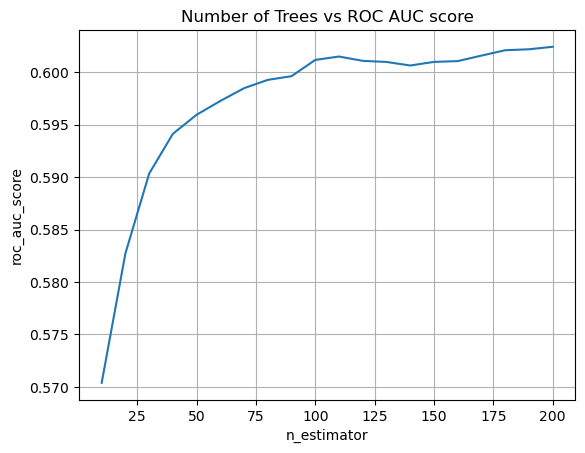

In [9]:
df_scores_nest = pd.DataFrame(scores_nest, columns=["n_estimator","roc_auc_score","elapsed_time"])

ax = sns.lineplot(data=df_scores_nest, x="n_estimator", y="roc_auc_score")

plt.grid(True)
plt.title("Number of Trees vs ROC AUC score")
plt.show()

In this **Computational Time vs ROC AUC Score** graph, the plateau is more evident: we can see that the roc_auc_score barely changes after 120 trees.

Text(0.5, 1.0, 'Computational Time vs ROC AUC Score')

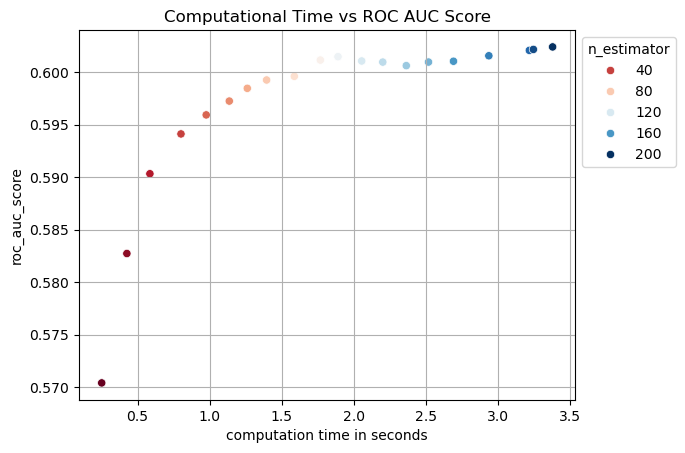

In [10]:
ax = sns.scatterplot(data=df_scores_nest, x="elapsed_time", y="roc_auc_score", hue="n_estimator", palette="RdBu")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("computation time in seconds")
plt.grid(True)
plt.title("Computational Time vs ROC AUC Score")

**Conclusion**

We can see that there is a substantial increase in the performance of the model initially but then this plateaus at around the 100 mark.

At this point our `roc_auc_score` sits at just above 0.6. This is an improvement from our base model that had an `roc_auc_score` of 0.57.

In [11]:
df_scores_nest.sort_values(by="roc_auc_score", ascending=False).head(10)

,n_estimator,roc_auc_score,elapsed_time
19,200,0.602412,3.380444
18,190,0.602174,3.247166
17,180,0.602083,3.219080
16,170,0.601569,2.937884
10,110,0.601483,1.890967
9,100,0.601161,1.768609
11,120,0.601072,2.055375
15,160,0.601047,2.692471
14,150,0.600971,2.519121
12,130,0.600967,2.201754


### What is the best max depth?

The depth of the decision tree is the number of levels from the root node to furthest leaf node.

Our base model's depth is set to None at the moment (default value) which means that the tree will keep branching and growing until each leaf contains only one class (or it hits the limit imposed by another parameter `min_samples_leaf`. Without restriction, its max depth was 105. 

A deeper tree has more levels of decision making which means that the model can capture more complexity. However it can also result in overfitting not to mention a higher computational.

In [12]:
# This took around 7 minutes on my machine when n_jobs=None, setting n_jobs=-1 speeds this up to under 90 seconds!
scores_md = []
number_trees = range(10,201,20)
max_depths = [5,10,20,30,40,80]

for d in tqdm(max_depths):
    for n in tqdm(number_trees):
        start_time = time.time()
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1) # setting n_jobs=-1 uses all processors 
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val, y_pred)
        end_time = time.time()
        elapsed_time = end_time - start_time
        scores_md.append((d, n, score, elapsed_time))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
columns = ["max_depth", "n_estimator","roc_auc_score", "computational_time"]
df_scores_md = pd.DataFrame(scores_md, columns=columns)
df_scores_md.sort_values(by="roc_auc_score", ascending=False).head()

,max_depth,n_estimator,roc_auc_score,computational_time
18,10,170,0.628463,1.834272
19,10,190,0.628441,1.815756
17,10,150,0.628342,1.525465
16,10,130,0.627801,1.362356
15,10,110,0.627364,1.217525


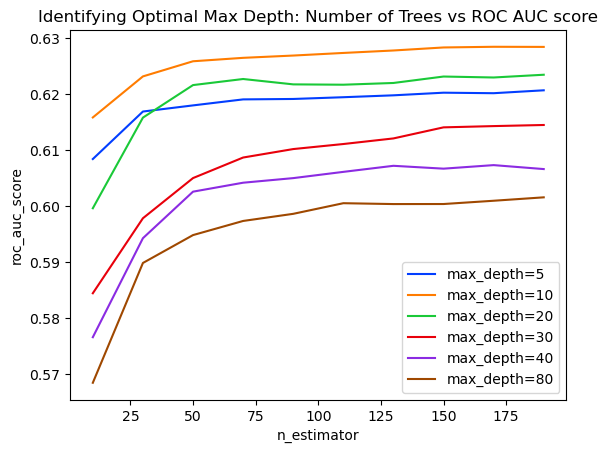

In [14]:
sns.set_palette("bright")

for d in max_depths:
    df_subset = df_scores_md[df_scores_md["max_depth"] == d]
    sns.lineplot(data=df_subset, x="n_estimator", y="roc_auc_score", label='max_depth=%d' % d)

plt.title("Identifying Optimal Max Depth: Number of Trees vs ROC AUC score")
plt.show()

We can see from the graph that a `max_depth` of 10 is the clear winner in this scenario.

When we tune `max_depth` our `roc_auc_score` improves again and in comparison to just tuning the number of trees, the computational timing drops: Even with 170 trees, with `max_depth` set to 10, we see our `roc_auc_score` improve to 0.628.

This is not a huge change from the 0.6 mark achieved by tuning the number of trees but is still worthwhile.

### What is the minimum number of samples that should exist at each leaf node?

A leaf node is the last node in a decision tree where you finally get to a decision point, in our case, we get an answer(probability) of whether our collision is severe.

In our base model and by default `min_samples_leaf` is set to 1, which means we have only one sample to back up this decision. If most of our leaf nodes have only one sample it can mean that our whole decision tree may perform well for our training set but badly on other datasets i.e. suffer from overfitting.

To avoid overfitting, we can modify the `min_samples_leaf`

We test out different values of `min_samples_leaf` setting `max_depth` to 10

In [18]:
# This took around 5 minutes on my machine with n_jobs=None, but under 90 seconds when n_jobs=-1
max_depth = 10

scores_msl = []
number_trees = range(10,201,20)
min_samples_at_leaf = [1,3,5,10,50]

for s in tqdm(min_samples_at_leaf):
    for n in tqdm(number_trees):
        start_time = time.time()
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, random_state=1, min_samples_leaf=s, n_jobs=-1) 
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val, y_pred)
        end_time = time.time()
        elapsed_time = end_time - start_time
        scores_msl.append((s, n, score, elapsed_time))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
columns = ["min_samples_at_leaf", "n_estimator","roc_auc_score", "computational_time"]
df_scores_msl = pd.DataFrame(scores_msl, columns=columns)
df_scores_msl.sort_values(by="roc_auc_score", ascending=False).head(20)

,min_samples_at_leaf,n_estimator,roc_auc_score,computational_time
25,5,110,0.628883,1.115515
27,5,150,0.628818,1.444471
24,5,90,0.628806,0.937622
29,5,190,0.628672,1.951013
17,3,150,0.628617,1.511251
26,5,130,0.628571,1.296729
28,5,170,0.628562,1.770215
14,3,90,0.628524,0.954166
15,3,110,0.628506,1.154835
8,1,170,0.628463,1.749845


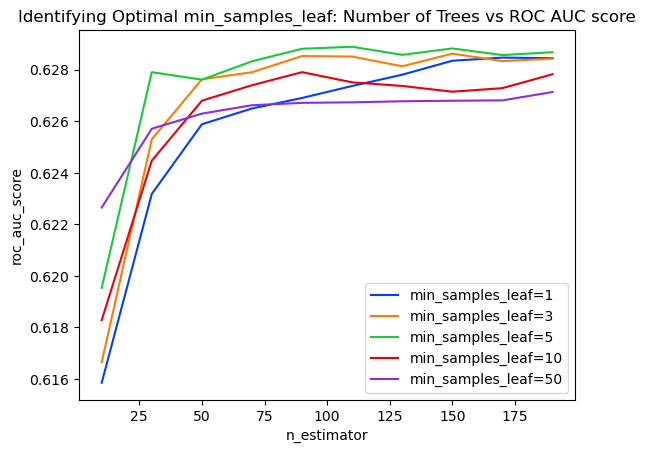

In [20]:
sns.set_palette("bright")

for s in min_samples_at_leaf:
    df_subset = df_scores_msl[df_scores_msl["min_samples_at_leaf"] == s]
    sns.lineplot(data=df_subset, x="n_estimator", y="roc_auc_score", label='min_samples_leaf=%d' % s)

plt.title("Identifying Optimal min_samples_leaf: Number of Trees vs ROC AUC score")
plt.show()

We can see from the graph that the best `min_samples_leaf` value is 5: it consistently has a higher `roc_auc_score` topping out at `0.6288`.

One thing that is worth noting is that the number of estimators to achieve this higher scores is consistently larger (the lowest n_estimator that achieves 0.6288 is 90 trees). That being said, we can achieve a score of `0.6279` with only 30 trees.

I know we should balance speed and performance and these gains in performance seem small. So too, however do the gains in time! For this reason, I will stick with the larger `n_estimator` value which produces the top `0.6288` score i.e. `n_estimators=110`

### Is there a way for us to handle the fact that we have imbalanced data?

In lectures it was suggested that we play around with the `bootstrap` variable. I have an unbalanced dataset (70% of my data is not classified as severe. 

`bootstrap` is set to True already by default in the RandomForestClassifier so we are already getting the benefits... but is it helping?

I thought bootstrapping would help because bootstrapping samples the data with replacement i.e. it's possible that it will randomly sample a lot more rows where `is_severe` == 1 than actually exist in the dataset. 

The method can increase the diversity of the trees used in the forest because each tree will be trained on a slightly different subset of the data. 

**class_weight**

The `class_weight` parameter allows you to assign a higher weight to the target variable i.e. `is_severe`. 

Setting the `class_weight='balanced'` means that more weight will be given to getting the minority class (`is_severe=1`) classified correctly. What the model does in practice is penalise misclassifications  of the minority class more, encouraging the model to be more careful about classifying those examples. 

In [26]:
df_collision["is_severe"].value_counts(normalize=True)

is_severe
0    0.701881
1    0.298119
Name: proportion, dtype: float64

In [27]:
max_depth = 10
min_samples_leaf = 5

scores_boot = []
number_trees = range(10,201,20)
bootstrap = [True,False]
class_weight=[None, "balanced"]

for b in tqdm(bootstrap):
    for cw in tqdm(class_weight):
        for n in tqdm(number_trees):
            start_time = time.time()
            rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, random_state=1, 
                                        min_samples_leaf=min_samples_leaf, n_jobs=-1, bootstrap=b, class_weight=cw) 
            rf.fit(X_train,y_train)
            y_pred = rf.predict_proba(X_val)[:,1]
            score = roc_auc_score(y_val, y_pred)
            end_time = time.time()
            elapsed_time = end_time - start_time
            scores_boot.append((b, cw, n, score, elapsed_time))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
columns = ["bootstrap", "class_weight", "n_estimator","roc_auc_score", "computational_time"]
df_scores_boot_cw = pd.DataFrame(scores_boot, columns=columns)
df_scores_boot_cw.sort_values(by="roc_auc_score", ascending=False).head(10)

,bootstrap,class_weight,n_estimator,roc_auc_score,computational_time
5,True,None,110,0.628883,1.195517
7,True,None,150,0.628818,1.547730
4,True,None,90,0.628806,0.967575
9,True,None,190,0.628672,1.858227
6,True,None,130,0.628571,1.316189
8,True,None,170,0.628562,1.672895
3,True,None,70,0.628319,0.812389
37,False,balanced,150,0.628298,2.163889
39,False,balanced,190,0.628225,2.678598
38,False,balanced,170,0.628204,2.408423


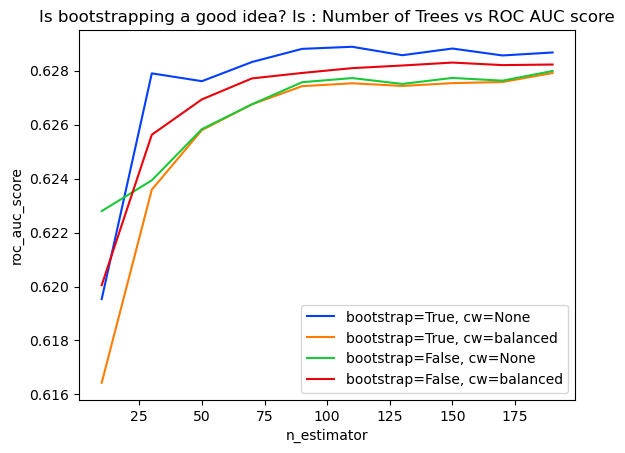

In [29]:
sns.set_palette("bright")

for b in bootstrap:
    for cw in class_weight:
        filter_cw = df_scores_boot_cw["class_weight"] == cw
        if not cw:
            filter_cw = df_scores_boot_cw["class_weight"].isna()
        df_subset = df_scores_boot_cw[(df_scores_boot_cw["bootstrap"] == b) & (filter_cw) ]
        sns.lineplot(data=df_subset, x="n_estimator", y="roc_auc_score", label=f'bootstrap={b}, cw={cw}')

plt.title("Is bootstrapping a good idea? Is : Number of Trees vs ROC AUC score")
plt.show()

The results may seem a little surprising. 

Why does our model seems to be worst when there is bootstrapping and we attempt to handle the class imbalance with the `class_weight` parameter? 

We assumed that bootstrapping would help our class imbalance problem but it's possible for it to exacerabate it: perhaps random sampling actually means an even worse split is chosen! If you are going to do bootstrapping, it seems that this is best done for our dataset without setting the `class_weight` parameter i.e. stick with the defaults!

So far we have tuned `max_depth` and `max_samples_leaf` and improved the `roc_auc_score` to 0.6288. By playing around with `bootstrap` and `class_weight`, we don't get any additional improvement 

So after this stage our final tuning is

- `max_depth` = 10
- `min_samples_leaf` = 5
- `n_estimators` = 110

In [30]:
max_depth = 10
min_samples_leaf = 5
n_estimators = 110

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1, min_samples_leaf=min_samples_leaf, n_jobs=-1) 
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score_tuning = roc_auc_score(y_val, y_pred)
roc_auc_score_tuning

np.float64(0.6288830973285102)

## Final model

I will use the full training set to train a model with the parameters found in the model tuning evaluation above.

In [31]:
# Prepare datasets: `is_severe` still exists in df_full_train so we need to remove it and extract the y_full_train

df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train["is_severe"].values

del df_full_train["is_severe"]

# Create dv and X_full_train and X_test datasets
dicts_full_train = df_full_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(dicts_full_train)
X_full_train = dv.transform(dicts_full_train)

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)

max_depth = 10
min_samples_leaf = 5
n_estimators = 90

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1, min_samples_leaf=min_samples_leaf, n_jobs=-1) 
rf.fit(X_full_train,y_full_train)

y_pred_test = rf.predict_proba(X_test)[:,1]
roc_auc_score_final = roc_auc_score(y_test, y_pred_test)
roc_auc_score_final

np.float64(0.6222136888244261)

In [32]:
np.round(roc_auc_score_tuning,3) - np.round(roc_auc_score_final,3)

np.float64(0.007000000000000006)

### Final model evaluation

Our final model has a lower score (0.622 vs 0.629) than the model we built with the training set alone: the difference is a little greater than 0.007. This is a fraction of a percent so we can say that our model didn't overfit and generalised quite well to unseen data.

That being said, the `roc_auc_score` for this model is quite low. It is better than our logistic regression model, but only slightly.

## Feature importance

The Random Forest classifier provides an array of the relative feature importances: the higher the number, the more important the feature.

With more time we could use this information to refine our features or drop some. It looks like the numerical columns and simple binary columns were more important: perhaps some of our categorical columns are unnecessary or perhaps they are too complex.

In [33]:
feature_importance = rf.feature_importances_
feature_name = dv.get_feature_names_out()

df_feature_importance = pd.DataFrame({"feature_name": feature_name, "feature_importance": feature_importance})
df_feature_importance.sort_values(by="feature_importance", ascending=False).head(10)

,feature_name,feature_importance
37,number_of_vehicles,0.201483
69,police_force=police_scotland,0.116638
62,police_force=metropolitan_police,0.052106
7,day_of_year,0.051950
93,speed_limit,0.049014
19,is_urban,0.031400
90,road_type=single_carriageway,0.026444
16,is_near_junction,0.025977
79,police_force=west_midlands,0.014235
87,road_type=dual_carriageway,0.013010


In [34]:
df_feature_importance.sort_values(by="feature_importance", ascending=False).tail(10)

,feature_name,feature_importance
22,light_conditions=darkness___lights_unlit,0.000779
92,road_type=unknown,0.000578
125,weather_conditions=snowing_no_high_winds,0.000508
43,police_force=cleveland,0.000422
83,road_surface_conditions=flood_over_3cm._deep,0.000393
9,first_road_class=a(m),0.000349
85,road_surface_conditions=snow,0.000301
120,weather_conditions=fog_or_mist,0.000282
124,weather_conditions=snowing__high_winds,0.000049
42,police_force=city_of_london,0.000031
